In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import itertools
import os
import shutil
import random

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Markdown as md

### Dataset

This data set contains images of sign language digits. There are ten classes, labeled as `0` through `9`, and each class is made up of images of hands showing the sign for that particular digit.

This does not have classes that were included in ImageNet, nor very similar to the ImageNet classes that MobileNet was originally trained on. We'll later go through the process together for tuning the model to predict on this new data.

Each class has between `204` and `208` samples. The total data set contains `2062` samples.

This data set is available as grayscale images on [Kaggle](https://kaggle.com/ardamavi/sign-language-digits-dataset) and is also available as RGB images on [Github](https://github.com/ardamavi/Sign-Language-Digits-Dataset). We'll be using the RGB data set.

After downloading, lets split the dataset into train test and validation directories.

In [2]:
# Organize data into train, valid, test dirs
os.chdir('data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

### Process The Data

After our image data is all organized on disk, we need to create the directory iterators for the train, validation, and test sets.

In [3]:
train_path = 'data/Sign-Language-Digits-Dataset/train'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'
test_path  = 'data/Sign-Language-Digits-Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory = train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory = valid_path, target_size=(224,224), batch_size=10)
test_batches  = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory = test_path,  target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


### Fine-tunning the `Mobile Net`

In [4]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [5]:
len(mobile.layers)

91

Next, we are going to grab the output from the sixth to last layer of the model and store it a variable `x`. This choice is based on some pre-experiments.

In [6]:
x = mobile.layers[-4].output

In [7]:
model = Model(inputs=mobile.input, outputs=x)
print(len(model.layers))

88


We'll be using this to build a new model. This new model will consist of the original `MobileNet` up to the last `global_average_pooling` layer. We're not including the last five layers of the original `MobileNet`.

So with this setup, we'll be keeping the vast majority of the original MobileNet architecutre, which has `88` layers total.

In [8]:
print(model.layers[-1].get_output_at(0).get_shape())

(None, 1, 1, 1024)


We need to Flatten the last layer of the `model` before defining a dense output. It changes the size `(None, 1, 1, 1024)` to `(None, 1024)`.

In [9]:
mod_x = Flatten()(x)

Now, we create an output layer that we're calling output, which will just be a Dense layer with `10` output nodes for the ten corresponding classes, and we'll use the `softmax` activation function.

In [10]:
output = Dense(units=10, activation='softmax')(mod_x)

In [11]:
model = Model(inputs=mobile.input, outputs=output)
len(model.layers)

90

Note, you can see by the `Model`, constructor used to create our model, that this is a model that is being created with the Keras `Functional` API, not the `Sequential` API that we've worked with in previous `VGG16` model.

To build the new model, we create an instance of the Model class and specify the inputs to the model to be equal to the input of the original `MobileNet`, and then we define the outputs of the model to be equal to the output variable we created directly above.

This creates a new model, which is identical to the original `MobileNet` up to the original model's sixth to last layer. We don't have the last five original `MobileNet` layers included, but instead we have a new layer, the output layer we created with ten output nodes.

**Now, we need to choose how many layers we actually want to be trained when we train on our new data set.**

We still want to keep a lot of what the original MobileNet has already learned from `ImageNet` by freezing the weights in many of layers, especially earlier ones, but we do indeed need to train some layers since the model still needs to learn features about this new data set.

I did a little experimenting and found that **training the last 23 layers** will give us a pretty decently performing model.

In [12]:
for layer in model.layers[:-22]:
    layer.trainable = False

In [13]:
model.layers[-1].get_output_at(0).get_shape()

TensorShape([None, 10])

In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

### Train The Model

In [15]:
model.compile(optimizer=Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
try:
    model = load_model('models/Hand-sign-MobileNet.model.h5')
except:   
    model.fit(x = train_batches,
              steps_per_epoch = len(train_batches),
              validation_data = valid_batches,
              validation_steps = len(valid_batches),
              epochs = 10,
              verbose = 2)

Epoch 1/10
172/172 - 90s - loss: 0.6521 - accuracy: 0.8131 - val_loss: 0.8314 - val_accuracy: 0.6933 - 90s/epoch - 524ms/step
Epoch 2/10
172/172 - 96s - loss: 0.1140 - accuracy: 0.9836 - val_loss: 0.1654 - val_accuracy: 0.9700 - 96s/epoch - 558ms/step
Epoch 3/10
172/172 - 103s - loss: 0.0537 - accuracy: 0.9947 - val_loss: 0.1182 - val_accuracy: 0.9800 - 103s/epoch - 598ms/step
Epoch 4/10
172/172 - 109s - loss: 0.0378 - accuracy: 0.9953 - val_loss: 0.1004 - val_accuracy: 0.9800 - 109s/epoch - 636ms/step
Epoch 5/10
172/172 - 110s - loss: 0.0274 - accuracy: 0.9971 - val_loss: 0.1286 - val_accuracy: 0.9733 - 110s/epoch - 639ms/step
Epoch 6/10
172/172 - 108s - loss: 0.0214 - accuracy: 0.9971 - val_loss: 0.0929 - val_accuracy: 0.9867 - 108s/epoch - 628ms/step
Epoch 7/10
172/172 - 120s - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.0780 - val_accuracy: 0.9933 - 120s/epoch - 698ms/step
Epoch 8/10
172/172 - 109s - loss: 0.0132 - accuracy: 0.9977 - val_loss: 0.0824 - val_accuracy: 0.9933 - 109s

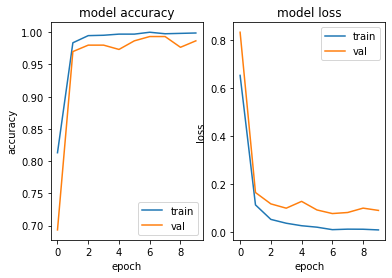

In [25]:
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

Model was trained with almost `100%` traiding and validation accuracy early on. Let's save it and do inference on the test set.

In [27]:
if os.path.isfile('models/Hand-sign-MobileNet.model.h5') is False:
    model.save('models/Hand-sign-MobileNet.model.h5')

### Use The Model For Inference

In [28]:
test_labels = test_batches.classes
predictions = model.predict(x = test_batches, 
                            steps = len(test_batches), 
                            verbose = 0)
predictions = np.round(predictions)

In [31]:
cm = confusion_matrix(y_true = test_labels, 
                      y_pred = predictions.argmax(axis=1))

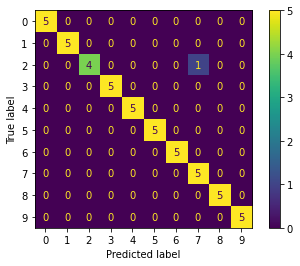

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = test_batches.class_indices)
disp.plot()
plt.show()